# Q-Learning with NN

In [1]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
%matplotlib inline

In [11]:
env = gym.make('CartPole-v0')

tf.reset_default_graph()

NUM_ACTIONS = env.action_space.n  # 0 or 1

n = 3

n_input = 4 * n
n_hidden_1 = 64
n_hidden_2 = 32
n_hidden_3 = 16
n_out = 2

weights = {
    'h1' : tf.Variable(tf.random_uniform([n_input, n_hidden_1], 0, 0.01)),
    'h2' : tf.Variable(tf.random_uniform([n_hidden_1, n_hidden_2], 0, 0.01)),
    'h3' : tf.Variable(tf.random_uniform([n_hidden_2, n_hidden_3], 0, 0.01)),
    'out' : tf.Variable(tf.random_uniform([n_hidden_3, n_out], 0, 0.01))
}


def multilayer_model(x, weights):
    layer_1 = tf.matmul(x, weights['h1'])
    layer_2 = tf.nn.relu(tf.matmul(layer_1, weights['h2']))
    layer_3 = tf.matmul(layer_2, weights['h3'])
    out_layer = tf.nn.softmax(tf.matmul(layer_3, weights['out']))
    return out_layer


inputs1 = tf.placeholder(shape=[None, n_input], dtype=tf.float32)

q_out = multilayer_model(inputs1, weights)
predict = tf.argmax(q_out, 1)

next_q = tf.placeholder(shape=[None, n_out], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(next_q - q_out))
update_model = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)

init = tf.initialize_all_variables()


discount_factor = 0.99
exploration_rate = 0.3
NUM_EPISODES = 500
MAX_T = 250
DEBUG = True


step_list = []
reward_list = []
prev_states = []
with tf.Session() as sess:
    sess.run(init)
    for episode in range(NUM_EPISODES):
        state_0 = env.reset()
        
        
        reward_all = 0
        t = 0
        while t < MAX_T:
            t += 1
            
            prev_states.append(state_0.reshape((1,4)))
            input_vec_0 = None
            ###############
            if len(prev_states) < n:
                input_vec_0 = np.zeros((1, 4 * (n-len(prev_states))))
                for i in range(len(prev_states)):
                    input_vec_0 = np.concatenate((input_vec_0, prev_states[i]), axis=1)
            else:
                for pr_st in prev_states[-n:]:
                    if input_vec_0 is None:
                        input_vec_0 = pr_st
                    else:
                        input_vec_0 = np.concatenate((input_vec_0, pr_st), axis=1)
            ###############
            
            action, all_q = sess.run([predict, q_out], feed_dict={inputs1:input_vec_0})
            if t > 300:
                exploration_rate = 0.001
                
            if np.random.rand(1) < exploration_rate:
                action[0] = env.action_space.sample()
            
            state, reward, done, _ = env.step(action[0])
            
            
            prev_states.append(state.reshape((1,4)))
            input_vec = None
            ###############
            if len(prev_states) < n:
                input_vec = np.zeros((1, 4 * (n-len(prev_states))))
                for i in range(len(prev_states)):
                    input_vec = np.concatenate((input_vec, prev_states[i]), axis=1)
            else:
                for pr_st in prev_states[-n:]:
                    if input_vec is None:
                        input_vec = pr_st
                    else:
                        input_vec = np.concatenate((input_vec, pr_st), axis=1)
            ###############
            
            q1 = sess.run(q_out, feed_dict={inputs1:input_vec})
    
            max_q1 = np.max(q1)
            
            target_q = all_q
            
            target_q[0, action[0]] = reward + discount_factor * max_q1
            
            _ = sess.run([update_model], feed_dict={inputs1:input_vec_0, next_q:target_q})
            
            reward_all += reward
            state_0 = state
            
            if done:
                if DEBUG:
                    print("Episode {} finished after {} timesteps".format(episode, t))
                break
                
        step_list.append(t)
        reward_list.append(reward_all)
        
print("Average score: {}".format(sum(reward_list)/NUM_EPISODES))
env.close()

[2017-03-10 15:40:34,752] Making new env: CartPole-v0


Episode 0 finished after 59 timesteps
Episode 1 finished after 49 timesteps
Episode 2 finished after 115 timesteps
Episode 3 finished after 76 timesteps
Episode 4 finished after 75 timesteps
Episode 5 finished after 163 timesteps
Episode 6 finished after 27 timesteps
Episode 7 finished after 122 timesteps
Episode 8 finished after 125 timesteps
Episode 9 finished after 107 timesteps
Episode 10 finished after 103 timesteps
Episode 11 finished after 109 timesteps
Episode 12 finished after 131 timesteps
Episode 13 finished after 109 timesteps
Episode 14 finished after 63 timesteps
Episode 15 finished after 119 timesteps
Episode 16 finished after 101 timesteps
Episode 17 finished after 74 timesteps
Episode 18 finished after 150 timesteps
Episode 19 finished after 79 timesteps
Episode 20 finished after 138 timesteps
Episode 21 finished after 58 timesteps
Episode 22 finished after 90 timesteps
Episode 23 finished after 79 timesteps
Episode 24 finished after 34 timesteps
Episode 25 finished af

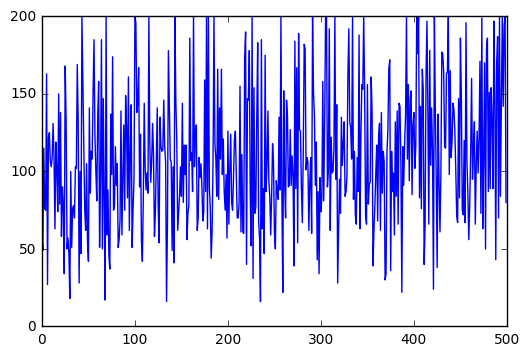

In [12]:
plt.plot(reward_list)

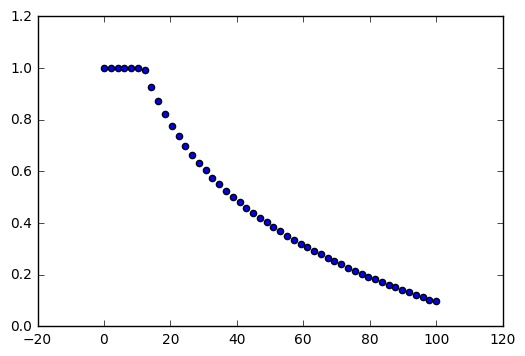

In [96]:
def get_explore_rate(t):
    return max(0.1, min(1, 1.0 - math.log10((2*t+1)/25)))

t = np.linspace(0,100)
y = [get_explore_rate(i) for i in t]
plt.scatter(t, y)